In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences

from deepctr.feature_column import SparseFeat, VarLenSparseFeat, get_feature_names
from deepctr.models import DeepFM

In [2]:
data = pd.read_csv("./data/movielens_sample.txt")

In [3]:
sparse_features = ["movie_id", "user_id",
                       "gender", "age", "occupation", "zip", ]

data[sparse_features] = data[sparse_features].astype(str)
target = ['rating']

In [4]:
# Use hashing encoding on the fly for sparse features, and process sequence features
genres_list = list(map(lambda x: x.split('|'), data['genres'].values))
genres_length = np.array(list(map(len, genres_list)))
max_len = max(genres_length)

# Notice : padding=`post`
genres_list = pad_sequences(genres_list, maxlen=max_len, padding='post', dtype=object, value=0).astype(str)

In [5]:
# Set hashing space for each sparse field and generate feature config for sequence feature
fixlen_feature_columns = [SparseFeat(feat, data[feat].nunique() * 5, embedding_dim=4, use_hash=True, dtype='string')
                            for feat in sparse_features]
varlen_feature_columns = [
    VarLenSparseFeat(SparseFeat('genres', vocabulary_size=100, embedding_dim=4, use_hash=True, dtype="string"),
                        maxlen=max_len, combiner='mean',
                        )]  # Notice : value 0 is for padding for sequence input feature
linear_feature_columns = fixlen_feature_columns + varlen_feature_columns
dnn_feature_columns = fixlen_feature_columns + varlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [6]:
# Generate input data for model
model_input = {name: data[name] for name in feature_names}
model_input['genres'] = genres_list

In [7]:
# Define Model,compile and train
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression')

model.compile("adam", "mse", metrics=['mse'], )
history = model.fit(model_input, data[target].values,
                    batch_size=256, epochs=100, verbose=2, validation_split=0.2, )

Epoch 1/100
1/1 - 8s - loss: 14.3000 - mse: 14.3000 - val_loss: 13.3749 - val_mse: 13.3749
Epoch 2/100
1/1 - 0s - loss: 14.1540 - mse: 14.1540 - val_loss: 13.2217 - val_mse: 13.2217
Epoch 3/100
1/1 - 0s - loss: 13.9777 - mse: 13.9777 - val_loss: 13.0573 - val_mse: 13.0573
Epoch 4/100
1/1 - 0s - loss: 13.7890 - mse: 13.7890 - val_loss: 12.8781 - val_mse: 12.8781
Epoch 5/100
1/1 - 0s - loss: 13.5837 - mse: 13.5837 - val_loss: 12.6815 - val_mse: 12.6815
Epoch 6/100
1/1 - 0s - loss: 13.3589 - mse: 13.3589 - val_loss: 12.4654 - val_mse: 12.4654
Epoch 7/100
1/1 - 0s - loss: 13.1127 - mse: 13.1127 - val_loss: 12.2281 - val_mse: 12.2281
Epoch 8/100
1/1 - 0s - loss: 12.8428 - mse: 12.8428 - val_loss: 11.9673 - val_mse: 11.9673
Epoch 9/100
1/1 - 0s - loss: 12.5463 - mse: 12.5463 - val_loss: 11.6807 - val_mse: 11.6807
Epoch 10/100
1/1 - 0s - loss: 12.2208 - mse: 12.2208 - val_loss: 11.3661 - val_mse: 11.3661
Epoch 11/100
1/1 - 0s - loss: 11.8632 - mse: 11.8632 - val_loss: 11.0210 - val_mse: 11.02

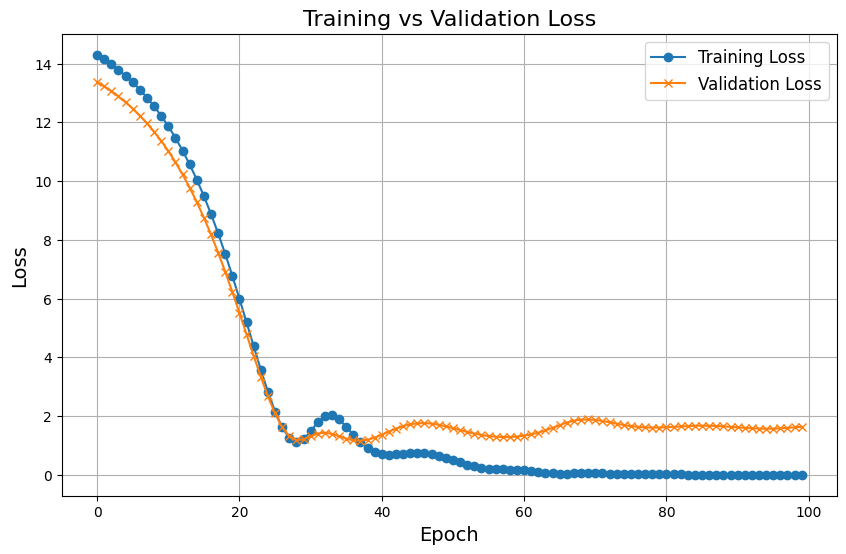

In [8]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='x')

plt.title("Training vs Validation Loss", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.show()

### Inference

In [11]:
import numpy as np

model_input = {'movie_id': np.array(['100']),
               'user_id': np.array(['20']),
               'gender': np.array(['1']),
               'age': np.array(['24']),
               'occupation': np.array(['15']),
               'zip': np.array(['77005']),
               'genres': np.array([['Action', 'Comedy', '0', '0', '0']])
}

In [12]:
model.predict(model_input)

array([[2.6855931]], dtype=float32)

In [15]:
# New Movie
model_input_nm = {'movie_id': np.array(['300']),
               'user_id': np.array(['20']),
               'gender': np.array(['1']),
               'age': np.array(['24']),
               'occupation': np.array(['15']),
               'zip': np.array(['77005']),
               'genres': np.array([['Romance', 'Drama', '0', '0', '0']])
}

model.predict(model_input_nm)

array([[2.701967]], dtype=float32)

In [17]:
# New user
model_input_nu = {'movie_id': np.array(['100']),
               'user_id': np.array(['300']),
               'gender': np.array(['0']),
               'age': np.array(['40']),
               'occupation': np.array(['20']),
               'zip': np.array(['99012']),
               'genres': np.array([['Action', 'Comedy', '0', '0', '0']])
}

model.predict(model_input_nu)

array([[2.3236969]], dtype=float32)